# Johnson & Johnson Time Series Forecasting (ARIMA Model Case Study)

In [2]:
# Import Libraries and Load the Data
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
# Load the dataset with date parsing
data = pd.read_csv('jj.csv', parse_dates=['date'])
data = data.set_index('date')
data = data.rename(columns={'data': 'Sales'})  # rename column 
print(data.head())
print("Data shape:", data.shape)


            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


# Visualize the Johnson & Johnson Sales Over Time

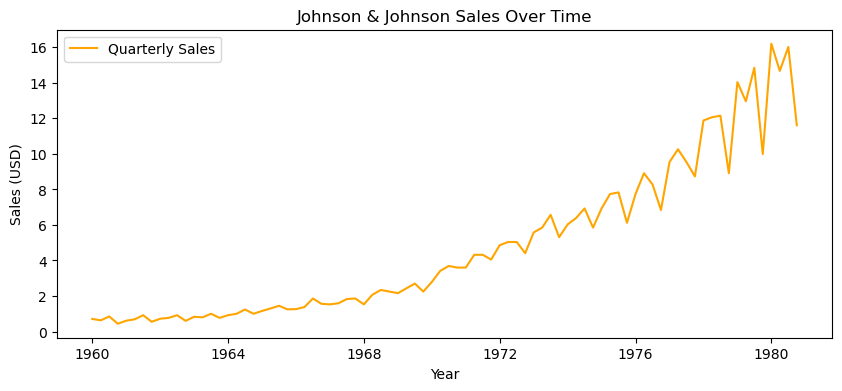

In [3]:
# Visualize the Original Time Series

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(data.index, data['Sales'], color='orange', label='Quarterly Sales')
plt.title('Johnson & Johnson Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()


# Stationarity (Augmented Dickey-Fuller Test)

In [4]:
# Check for Stationarity (Augmented Dickey-Fuller Test)

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")


ADF Statistic: 2.742
p-value: 1.000


In [5]:
# Here, Data is non-stationary (p>0.05), 
#This means we fail to reject the null hypothesis of a unit root.
# i.e,the time series is non-stationary 

# Make the Series Stationary (Log Transform and Differencing)

In [6]:
# Log transform the sales
log_sales = np.log(data['Sales'])

# Difference the log-transformed series
log_diff1 = log_sales.diff().dropna()

# ADF test on the differenced log series
result = adfuller(log_diff1)
print(f"ADF after 1st diff (log): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")


ADF after 1st diff (log): -4.317
p-value: 0.0004


# ACF and PACF for the Stationary Series

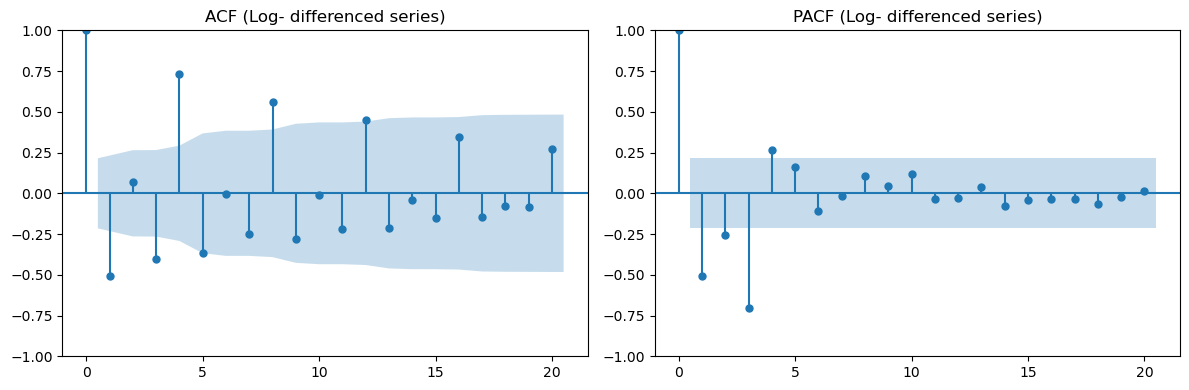

In [7]:
# Now stationary(p<0.05)

# Plot ACF and PACF for the Stationary Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(log_diff1, lags=20, ax=plt.gca(), title='ACF (Log- differenced series)')
plt.subplot(1,2,2)
plot_pacf(log_diff1, lags=20, ax=plt.gca(), title='PACF (Log- differenced series)')
plt.tight_layout()
plt.show()


# ARMA Model Fit (p,d,q)

In [8]:
# Manual Search for the Best ARIMA(p,d,q) Model using AIC
# Find Best ARIMA Model (Loop over p=0-6,d=0-2,q=0-6)

import statsmodels.api as sm

def find_best_arima(data, p_range, d_range, q_range):
    """
    Function to determine the best ARIMA model based on AIC.
    
    Parameters:
    data (pd.Series): Time series data.
    p_range (int): Maximum number of AR (Auto-Regressive) terms to consider.
    d_range (int): Maximum number of differences allowed.
    q_range (int): Maximum number of MA (Moving Average) terms to consider.
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = sm.tsa.arima.ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                    continue

    print(f"Best ARIMA order by AIC: {best_order}, AIC = {best_aic:.3f}")
    return best_order, best_aic, best_model


best_order, best_aic, best_model = find_best_arima(log_sales, 6, 2, 6)  


Best ARIMA order by AIC: (4, 1, 3), AIC = -144.198


# Fit the Best ARIMA Model and Examine the Results

In [9]:
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Wed, 09 Apr 2025   AIC                           -144.198
Time:                        19:32:07   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

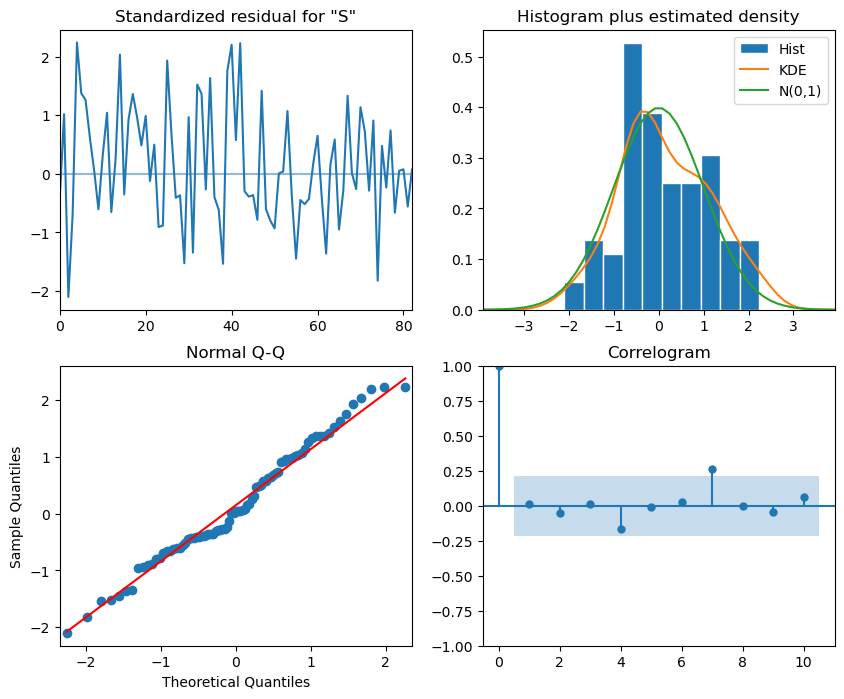

In [10]:
#Inspect the residual diagnostics

model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [11]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale) and convert to original scale
predictions = model_fit.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_log = predictions.predicted_mean
predicted_sales = np.exp(predicted_log)

# Align actual sales with predicted indices
actual_sales = data.loc[predicted_log.index, 'Sales']

# Calculate metrics
mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: 0.28
MSE: 0.16
RMSE: 0.40
MAPE: 8.21%


# Forecast the Next 24 Months (8 Quarters)

In [13]:
def forecast_arima(model_fit, steps, start_date):
    """
    Forecasts future values using an ARIMA model fit.
    
    Parameters:
    model_fit (ARIMAResults): The fitted ARIMA model.
    steps (int): Number of future steps to forecast.
    start_date (str): The starting date of the forecast period (YYYY-MM-DD).
    
    Returns:
    tuple: A tuple containing the forecast series, lower and upper confidence intervals.
    """
    # Get forecast result
    forecast_result = model_fit.get_forecast(steps=steps)
    log_forecast = forecast_result.predicted_mean
    log_conf_int = forecast_result.conf_int()
    
    # Convert forecasts back to original scale
    forecast = np.exp(log_forecast)
    conf_int_lower = np.exp(log_conf_int.iloc[:, 0])
    conf_int_upper = np.exp(log_conf_int.iloc[:, 1])
    
    # Set index for the forecast period
    forecast.index = pd.date_range(start=start_date, periods=steps, freq='Q')
    conf_int_lower.index = forecast.index
    conf_int_upper.index = forecast.index
    
    return forecast, conf_int_lower, conf_int_upper

n_steps = 8  # Forecast 8 quarters ahead
start_date = '1981-01-01'  # Starting date of the forecast period
forecast, conf_int_lower, conf_int_upper = forecast_arima(model_fit, n_steps, start_date)

# Display the forecast and confidence intervals
print("Forecast:")
print(forecast)
print("\nConfidence Interval Lower Bound:")
print(conf_int_lower)
print("\nConfidence Interval Upper Bound:")
print(conf_int_upper)


Forecast:
1981-03-31    18.040641
1981-06-30    16.652442
1981-09-30    18.003913
1981-12-31    13.452457
1982-03-31    20.327859
1982-06-30    18.816207
1982-09-30    20.201683
1982-12-31    15.522581
Freq: Q-DEC, Name: predicted_mean, dtype: float64

Confidence Interval Lower Bound:
1981-03-31    15.183629
1981-06-30    13.882934
1981-09-30    14.763898
1981-12-31    11.005079
1982-03-31    15.417940
1982-06-30    14.100820
1982-09-30    14.869924
1982-12-31    11.357666
Freq: Q-DEC, Name: lower Sales, dtype: float64

Confidence Interval Upper Bound:
1981-03-31    21.435241
1981-06-30    19.974439
1981-09-30    21.954965
1981-12-31    16.444097
1982-03-31    26.801366
1982-06-30    25.108444
1982-09-30    27.445196
1982-12-31    21.214790
Freq: Q-DEC, Name: upper Sales, dtype: float64


# Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)

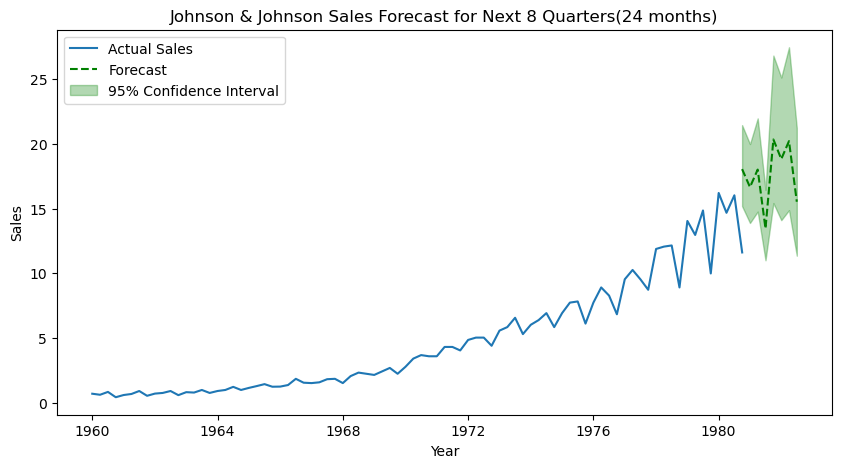

In [15]:
# Plot the Forecast vs Original Series

# Prepare index for forecast periods
forecast_index = pd.date_range(start='1980-08-01', periods=8, freq='Q')
# Plot the original series and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Sales'], label='Actual Sales')
plt.plot(forecast_index, forecast.values, label='Forecast', color='green', linestyle='--')
# Plot confidence interval as shaded area
plt.fill_between(forecast_index, conf_int_lower.values, conf_int_upper.values, 
                 color='green', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()


# ARIMA Time Series Modeling for Amazon Stock Price (Monthly)

In [16]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# If pmdarima is installed, import auto_arima
try:
    import pmdarima as pm
except ImportError:
    pm = None

In [17]:
# Data Preparation
# Load the dataset
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
# Examine the first few rows
print(df[['Close']].head())
print("Date range:", df.index.min(), "to", df.index.max())


                Close
Date                 
2018-02-20  73.417503
2018-02-21  74.146004
2018-02-22  74.266998
2018-02-23  75.000000
2018-02-26  76.097504
Date range: 2018-02-20 00:00:00 to 2023-02-17 00:00:00


In [18]:
# Resample to monthly frequency, taking the last closing price of each month
monthly_close = df['Close'].resample('M').last()
print("Number of monthly data points:", len(monthly_close))
print(monthly_close.head(5))   # display first 5 months as example
print(monthly_close.tail(5))   # display last 5 months as example


Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
2018-05-31    81.481003
2018-06-30    84.989998
Freq: M, Name: Close, dtype: float64
Date
2022-10-31    102.440002
2022-11-30     96.540001
2022-12-31     84.000000
2023-01-31    103.129997
2023-02-28     97.199997
Freq: M, Name: Close, dtype: float64


# Visualize the Monthly Closing Price Time Series

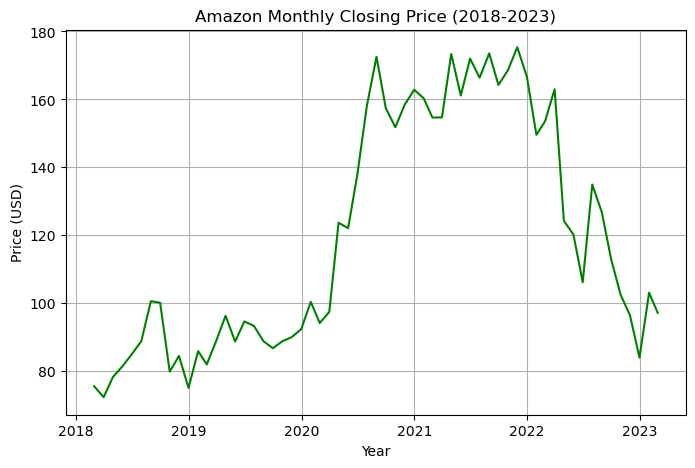

In [20]:
#Plot Amazon Monthly Closing Price
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, color='green')
plt.title('Amazon Monthly Closing Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

# Test for Stationarity with Augmented Dickey-Fuller (ADF) Test

In [21]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [22]:
#p-value < 0.05
#The p-value ~ 0.51 is much greater than 0.05, 
#fail to reject the null hypothesis

# Make the Series Stationary – Log Transform and Differencing

In [23]:
# Log Transformation
log_close = np.log(monthly_close)
result_log = adfuller(log_close.dropna())
print("ADF Statistic (log):", result_log[0])
print("p-value (log):", result_log[1])

ADF Statistic (log): -1.6666161408109945
p-value (log): 0.4483896872175652


In [24]:
#After log transformation, the p-value is ~0.45. 
#still p > 0.05, so the log series remains non-stationary.

In [25]:
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])

ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


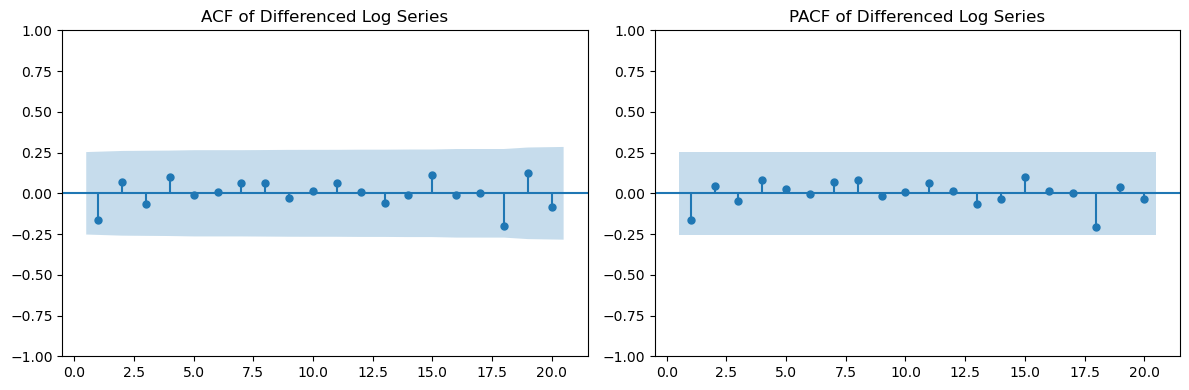

In [26]:
#After first differencing the log series, the p-value is essentially 0 (1.0e-14), which is far below 0.05.
#This means the differenced log series is stationary.

#Plot ACF and PACF of the Stationary Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('ACF of Differenced Log Series')
plt.subplot(1,2,2)
plot_pacf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('PACF of Differenced Log Series')
plt.tight_layout()
plt.show()

# ARMA Model Fit (p,d,q)

In [28]:
#Manual Grid Search for ARIMA(p,d,q) using AIC

def manual_grid_search_arima(data, max_p, max_q, d=1):
    """
    Perform a manual grid search to find the best ARIMA(p,d,q) model based on AIC.
    
    Parameters:
    data (pd.Series): The time series data on which to fit the ARIMA model.
    max_p (int): The maximum number of AR terms to consider.
    max_q (int): The maximum number of MA terms to consider.
    d (int): The order of differencing (default is 1).
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    warnings.filterwarnings("ignore")  # Ignore convergence warnings for some models
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):  # range starts at 0 and includes max_p
        for q in range(max_q + 1):  # range starts at 0 and includes max_q
            try:
                model = ARIMA(data, order=(p, d, q))
                res = model.fit()
                print(f"ARIMA({p},{d},{q}) AIC: {res.aic:.2f}")
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
            except Exception as e:
                print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                continue
    
    print(f"Best model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")
    return best_order, best_aic


best_order, best_aic = manual_grid_search_arima(log_close, max_p=9, max_q=9)


ARIMA(0,1,0) AIC: -107.97
ARIMA(0,1,1) AIC: -107.40
ARIMA(0,1,2) AIC: -105.61
ARIMA(0,1,3) AIC: -103.69
ARIMA(0,1,4) AIC: -102.42
ARIMA(0,1,5) AIC: -100.42
ARIMA(0,1,6) AIC: -98.44
ARIMA(0,1,7) AIC: -96.88
ARIMA(0,1,8) AIC: -95.09
ARIMA(0,1,9) AIC: -93.25
ARIMA(1,1,0) AIC: -107.56
ARIMA(1,1,1) AIC: -105.99
ARIMA(1,1,2) AIC: -104.02
ARIMA(1,1,3) AIC: -102.07
ARIMA(1,1,4) AIC: -100.42
ARIMA(1,1,5) AIC: -98.42
ARIMA(1,1,6) AIC: -97.01
ARIMA(1,1,7) AIC: -95.25
ARIMA(1,1,8) AIC: -93.38
ARIMA(1,1,9) AIC: -91.45
ARIMA(2,1,0) AIC: -105.73
ARIMA(2,1,1) AIC: -104.02
ARIMA(2,1,2) AIC: -102.08
ARIMA(2,1,3) AIC: -100.26
ARIMA(2,1,4) AIC: -98.83
ARIMA(2,1,5) AIC: -96.73
ARIMA(2,1,6) AIC: -97.36
ARIMA(2,1,7) AIC: -97.85
ARIMA(2,1,8) AIC: -91.28
ARIMA(2,1,9) AIC: -89.43
ARIMA(3,1,0) AIC: -103.89
ARIMA(3,1,1) AIC: -102.08
ARIMA(3,1,2) AIC: -100.20
ARIMA(3,1,3) AIC: -98.68
ARIMA(3,1,4) AIC: -96.93
ARIMA(3,1,5) AIC: -94.87
ARIMA(3,1,6) AIC: -97.63
ARIMA(3,1,7) AIC: -96.26
ARIMA(3,1,8) AIC: -89.41
ARIMA(3

In [29]:
# Chosen ARIMA(9,1,9) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(9, 1, 9))
results = model.fit()

In [30]:
#Model Summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(9, 1, 9)   Log Likelihood                  60.915
Date:                Wed, 09 Apr 2025   AIC                            -83.829
Time:                        19:41:16   BIC                            -44.037
Sample:                    02-28-2018   HQIC                           -68.264
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5176      1.482     -0.349      0.727      -3.422       2.386
ar.L2          0.1565      2.619      0.060      0.952      -4.977       5.290
ar.L3         -0.0347      2.948     -0.012      0.9

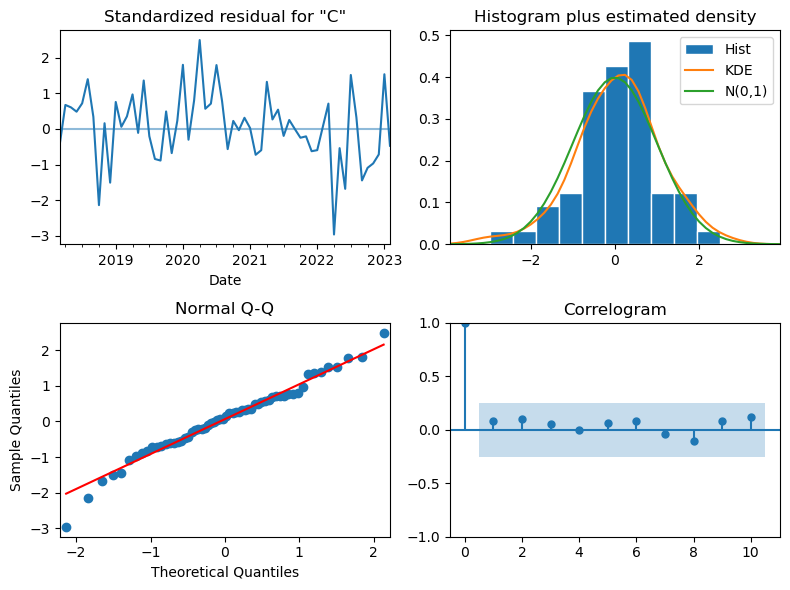

In [31]:
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

In [32]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale)
predictions = results.get_prediction(start=log_close.index[0], dynamic=False)
predicted_log = predictions.predicted_mean

# Convert to original scale and align with actual prices
predicted_prices = np.exp(predicted_log)
actual_prices = monthly_close.loc[predicted_log.index]

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: $8.82
MSE: $193.56
RMSE: $13.91
MAPE: 8.27%


# Forecast the Next 24 Months

In [33]:
# Generate forecasts for the next 24 months (in log scale)
# Convert the forecast mean and confidence interval to original scale

def forecast_and_convert(model_results, steps):
    """
    Generate forecasts for a given number of steps ahead using a fitted ARIMA model,
    and convert results from log scale to original scale.
    
    Parameters:
    model_results (ARIMAResults): The fitted ARIMA model from which to forecast.
    steps (int): Number of future steps to forecast.
    
    Returns:
    tuple: Tuple containing the forecasted mean values and confidence intervals in both scales.
    """
    # Generate forecasts in log scale
    forecast_log = model_results.get_forecast(steps=steps)
    log_forecast_mean = forecast_log.predicted_mean  # predicted log values
    log_conf_int = forecast_log.conf_int()           # confidence intervals in log scale

    # Convert the forecast and confidence intervals to original scale
    forecast_mean = np.exp(log_forecast_mean)  # Convert mean to original scale
    conf_lower = np.exp(log_conf_int.iloc[:, 0])  # Convert lower bound
    conf_upper = np.exp(log_conf_int.iloc[:, 1])  # Convert upper bound

    # Optionally, print the first few values to check
    print("First 5 forecasted log values:")
    print(log_forecast_mean[:5])
    print("First 5 forecasted original scale values:")
    print(forecast_mean[:5])

    return (log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper)


log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper = forecast_and_convert(results, 24)


First 5 forecasted log values:
2023-03-31    4.709997
2023-04-30    4.558673
2023-05-31    4.574901
2023-06-30    4.576817
2023-07-31    4.566680
Freq: M, Name: predicted_mean, dtype: float64
First 5 forecasted original scale values:
2023-03-31    111.051790
2023-04-30     95.456768
2023-05-31     97.018397
2023-06-30     97.204513
2023-07-31     96.224133
Freq: M, Name: predicted_mean, dtype: float64


# Plot the Forecast vs Historical Data with 95% Confidence Intervals

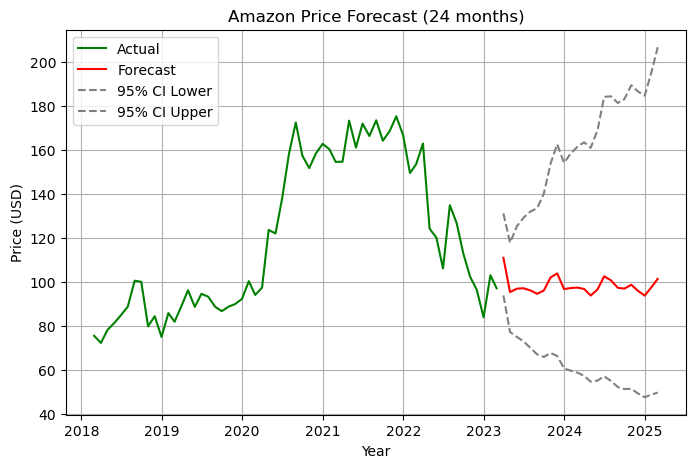

In [34]:
#plot actual vs forecast with intervals
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, label='Actual', color='green')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='red')
plt.plot(forecast_mean.index, conf_lower, color='gray', linestyle='--', label='95% CI Lower')
plt.plot(forecast_mean.index, conf_upper, color='gray', linestyle='--', label='95% CI Upper')
plt.title('Amazon Price Forecast (24 months)')
plt.xlabel('Year'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Time Series Forecasting with LSTM and GRU on Johnson & Johnson Sales Data

In [35]:
#Data Loading and Preprocessing

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# We will use TensorFlow Keras for building LSTM/GRU models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Load the Johnson & Johnson sales data
df = pd.read_csv('jj.csv', parse_dates=['date'])
df.set_index('date', inplace=True)    # set date column as index for time series
data = df['data']                     # extract the sales series

# Display basic info
print("Total observations:", len(data))
print("Start date:", data.index[0], "| End date:", data.index[-1])
print(data.head(5))  # preview the first few records


Total observations: 84
Start date: 1960-01-01 00:00:00 | End date: 1980-10-01 00:00:00
date
1960-01-01    0.71
1960-04-01    0.63
1960-07-02    0.85
1960-10-01    0.44
1961-01-01    0.61
Name: data, dtype: float64


In [36]:
# Define train/test split 
train_size = 76  # number of points in training set (1960-1978)
train = data.iloc[:train_size]
test  = data.iloc[train_size:]

print("Training period:", train.index[0].strftime('%Y-%m'), "to", train.index[-1].strftime('%Y-%m'),
      "| Test period:", test.index[0].strftime('%Y-%m'), "to", test.index[-1].strftime('%Y-%m'))
print("Training set length:", len(train), "| Test set length:", len(test))


Training period: 1960-01 to 1978-10 | Test period: 1979-01 to 1980-10
Training set length: 76 | Test set length: 8


In [37]:
# Apply log transformation to the training data
train_log = np.log(train.values)  # convert to numpy array of log values

# Apply first differencing to the log-transformed training data
train_log_diff = np.diff(train_log, n=1)  # first-order difference (result length will be len(train)-1)

print("First 5 values of log(train):", train_log[:5])
print("First 5 values of diff(log(train)):", train_log_diff[:5])
print("Length of differenced log series:", len(train_log_diff))


First 5 values of log(train): [-0.34249031 -0.46203546 -0.16251893 -0.82098055 -0.49429632]
First 5 values of diff(log(train)): [-0.11954515  0.29951653 -0.65846162  0.32668423  0.12323264]
Length of differenced log series: 75


# Preparing Data for RNN Models

In [39]:
# Prepare supervised learning sequences from the differenced log series
n_steps = 8  # window length (number of past observations to use for predicting the next one)
X_train = []
y_train = []

# Use the differenced log series (train_log_diff) to create input-output pairs
# Each X_train[i] will be a sequence of length n_steps, and y_train[i] will be the next value after that sequence.
for i in range(n_steps, len(train_log_diff)):
    X_train.append(train_log_diff[i-n_steps:i])
    y_train.append(train_log_diff[i])

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of X_train (samples, timesteps):", X_train.shape)
print("Shape of y_train (samples,):", y_train.shape)

# Feature scaling (normalize the differenced log data)
scaler = StandardScaler()
# Fit the scaler on the training input data (flattened) – since it's one-dimensional data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))  # scale all values in X_train
# Reshape back to original X_train shape after scaling
X_train_scaled = X_train_scaled.reshape(X_train.shape)
# Also scale the y_train values using the same scaler (they represent the next step of the same series)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).reshape(-1)

print("After scaling: mean =", X_train_scaled.mean(), ", std =", X_train_scaled.std())

# Reshape X_train for RNN input: from (samples, timesteps) to (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
print("Reshaped X_train for RNN:", X_train_scaled.shape)


Shape of X_train (samples, timesteps): (67, 8)
Shape of y_train (samples,): (67,)
After scaling: mean = -3.4798035100191475e-17 , std = 1.0
Reshaped X_train for RNN: (67, 8, 1)


# Building and Training the LSTM Model

In [40]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)))  # LSTM layer
model_lstm.add(Dense(1))  # output layer for forecasting the next value
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
epochs = 100
history_lstm = model_lstm.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=16, verbose=0, shuffle=True)

print("LSTM model training completed.")

LSTM model training completed.


# Building and Training the GRU Model

In [41]:
# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='tanh', input_shape=(n_steps, 1)))  # GRU layer
model_gru.add(Dense(1))  # output layer
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model on the same data
history_gru = model_gru.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=16, verbose=0, shuffle=True)

print("GRU model training completed.")

GRU model training completed.


# Forecasting 24 Months Ahead with LSTM and GRU

In [42]:
# Forecast horizon
n_forecast = len(test)  # number of steps to forecast (should be 8 for 2 years)

# Containers for forecasts (in original scale)
forecast_lstm = []
forecast_gru = []

# Starting window: last n_steps of training differenced log (scaled)
last_window = train_log_diff[-n_steps:]  # last 8 actual differenced log values from train
last_window_scaled = scaler.transform(last_window.reshape(-1, 1)).reshape(-1)  # scale them

# Get the last actual log value from training (to invert differencing)
last_log_value = train_log[-1]  # this is log of the last training actual data point (end of 1978)

for step in range(n_forecast):
    # Prepare input for LSTM (reshape to [1, n_steps, 1])
    X_input_lstm = np.array(last_window_scaled).reshape(1, n_steps, 1)
    # Predict the next diff (scaled) using LSTM
    pred_scaled_lstm = model_lstm.predict(X_input_lstm, verbose=0)
    # Prepare input for GRU similarly
    X_input_gru = np.array(last_window_scaled).reshape(1, n_steps, 1)
    pred_scaled_gru = model_gru.predict(X_input_gru, verbose=0)
    
    # Extract the scalar prediction from the arrays
    pred_scaled_value_lstm = pred_scaled_lstm[0, 0]
    pred_scaled_value_gru = pred_scaled_gru[0, 0]
    
    # Append the LSTM prediction to the window and drop the oldest value for next step
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_value_lstm)
    # (Note: We're using the same window for both models for simplicity; in practice, you might maintain separate windows if needed)
    
    # Invert scaling to get differenced log values
    pred_diff_lstm = scaler.inverse_transform([[pred_scaled_value_lstm]])[0, 0]
    pred_diff_gru  = scaler.inverse_transform([[pred_scaled_value_gru]])[0, 0]
    
    # Invert differencing to get the new log value for this forecast step
    last_log_value = last_log_value + pred_diff_lstm  # update last_log_value using LSTM's prediction
    log_pred_lstm = last_log_value
    # For GRU, we need the last actual log from train for first step, and thereafter we should use GRU's own last predicted log.
    # We can manage GRU's last log separately:
    # For first forecast step, both use last_log_value from train. Let's maintain separate last_log_value for GRU

# Forecast using the LSTM model
forecast_lstm = []
last_window_scaled = scaler.transform(train_log_diff[-n_steps:].reshape(-1,1)).reshape(-1)
last_log_value = train_log[-1]  # reset last log from train for LSTM

for step in range(n_forecast):
    X_input = last_window_scaled.reshape(1, n_steps, 1)
    pred_scaled = model_lstm.predict(X_input, verbose=0)
    pred_scaled_val = pred_scaled[0, 0]
    # Update sliding window
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_val)
    # Invert scaling and differencing
    pred_diff = scaler.inverse_transform([[pred_scaled_val]])[0, 0]
    # Compute forecasted log value and then original value
    last_log_value = last_log_value + pred_diff            # new log value
    pred_value = np.exp(last_log_value)                    # invert log to get original scale
    forecast_lstm.append(pred_value)

# Forecast using the GRU model
forecast_gru = []
last_window_scaled = scaler.transform(train_log_diff[-n_steps:].reshape(-1,1)).reshape(-1)
last_log_value = train_log[-1]  # reset last log from train for GRU

for step in range(n_forecast):
    X_input = last_window_scaled.reshape(1, n_steps, 1)
    pred_scaled = model_gru.predict(X_input, verbose=0)
    pred_scaled_val = pred_scaled[0, 0]
    # Update window
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_val)
    # Invert scaling and differencing
    pred_diff = scaler.inverse_transform([[pred_scaled_val]])[0, 0]
    last_log_value = last_log_value + pred_diff            # update log
    pred_value = np.exp(last_log_value)                    # back to original scale
    forecast_gru.append(pred_value)

# Convert forecasts to numpy arrays for convenience
forecast_lstm = np.array(forecast_lstm)
forecast_gru = np.array(forecast_gru)

print("LSTM forecast (original scale):", forecast_lstm)
print("GRU forecast (original scale):", forecast_gru)


LSTM forecast (original scale): [11.65540486 12.74933917 12.92070863 13.68319464 15.48109404 15.34000955
 14.18087355 12.53458703]
GRU forecast (original scale): [12.59211753 13.74772197 13.23351799 13.36126778 15.28198743 14.87057169
 14.18799417 14.28119909]


In [45]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual_test = test 
# Convert test series to numpy array for compatibility
actual_test_values = actual_test.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_test_values, forecast_lstm)
mse_lstm = mean_squared_error(actual_test_values, forecast_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_test_values - forecast_lstm) / actual_test_values)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_test_values, forecast_gru)
mse_gru = mean_squared_error(actual_test_values, forecast_gru)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_test_values - forecast_gru) / actual_test_values)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} {mae_lstm:.2f}{'':<10} {mae_gru:.2f}")
print(f"{'MSE':<10} {mse_lstm:.2f}{'':<10} {mse_gru:.2f}")
print(f"{'RMSE':<10} {rmse_lstm:.2f}{'':<10} {rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}{'':<10} {mape_gru:.2f}")


Model Performance Comparison:
Metric     LSTM            GRU            
MAE        1.55           1.61
MSE        3.54           3.51
RMSE       1.88           1.87
MAPE (%)   12.13           12.81


# Results Visualization
# Historical vs Forecasted JJ Sales for both LSTM and GRU

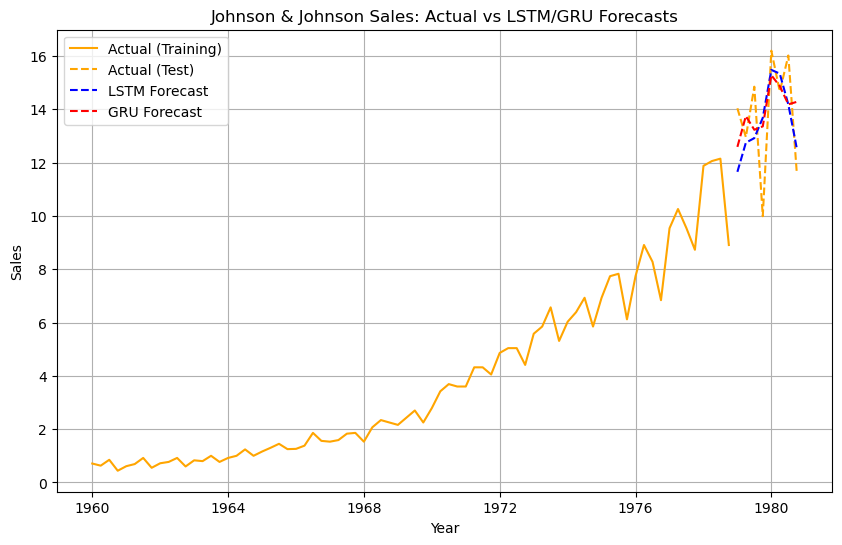

In [46]:
# Prepare actual values for plotting
actual_train = train  # 1960-1978 actual
actual_test = test    # 1979-1980 actual (to compare with forecasts)

plt.figure(figsize=(10,6))
# Plot actual historical data
plt.plot(actual_train.index, actual_train, label='Actual (Training)', color='orange')
plt.plot(actual_test.index, actual_test, label='Actual (Test)', color='orange', linestyle='--')
# Plot forecasts
plt.plot(actual_test.index, forecast_lstm, label='LSTM Forecast', color='blue', linestyle='--')
plt.plot(actual_test.index, forecast_gru, label='GRU Forecast', color='red', linestyle='--')

plt.title('Johnson & Johnson Sales: Actual vs LSTM/GRU Forecasts')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


# Forecasting Amazon Stock Price with RNNs (LSTM & GRU)

In [48]:
#Data Preparation

import pandas as pd

# Load the CSV data
df = pd.read_csv("AMZN.csv")
# Parse 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to monthly frequency using the last available closing price of each month
monthly_df = df['Close'].resample('M').last()

print("Date range:", monthly_df.index.min(), "to", monthly_df.index.max())
print("Number of monthly data points:", len(monthly_df))
print(monthly_df.head(3))  # show first 3 monthly prices


Date range: 2018-02-28 00:00:00 to 2023-02-28 00:00:00
Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: M, Name: Close, dtype: float64


# Stationarity Transformation (Log and Differencing)

In [49]:
# Apply log transformation to the monthly closing prices
log_series = np.log(monthly_df)

# Apply first-order differencing to the log-transformed series
diff_series = log_series.diff().dropna()

# Display a small sample of the differenced log series
print(diff_series.head(5))
print("Mean of differenced log series:", diff_series.mean())


Date
2018-03-31   -0.044003
2018-04-30    0.078880
2018-05-31    0.039739
2018-06-30    0.042164
2018-07-31    0.044664
Freq: M, Name: Close, dtype: float64
Mean of differenced log series: 0.004183614151600142


# Train-Test Split

In [50]:
# Define the split point: last 24 months for testing
train_series = monthly_df.iloc[:-24]  # all data except last 24 points
test_series  = monthly_df.iloc[-24:]  # last 24 months for test

print("Training period:", train_series.index.min(), "to", train_series.index.max(), f"({len(train_series)} months)")
print("Testing period:", test_series.index.min(), "to", test_series.index.max(), f"({len(test_series)} months)")


Training period: 2018-02-28 00:00:00 to 2021-02-28 00:00:00 (37 months)
Testing period: 2021-03-31 00:00:00 to 2023-02-28 00:00:00 (24 months)


In [51]:
# Differenced log series for the training period and testing period
train_diff = diff_series[:train_series.index.max()]  # up to Feb 2021 diff
test_diff  = diff_series[test_series.index.min():]   # from Mar 2021 diff onward

print(f"Training differenced series length: {len(train_diff)}")
print(f"Testing differenced series length: {len(test_diff)}")


Training differenced series length: 36
Testing differenced series length: 24


# Sliding Window Supervised Format

In [52]:
window_size = 12
train_diff_values = train_diff.values  # numpy array of training differenced log values

X = []
y = []
# Sliding window: use past 12 values to predict the next value
for i in range(window_size, len(train_diff_values)):
    X.append(train_diff_values[i-window_size:i])  # 12 values
    y.append(train_diff_values[i])               # next value

X = np.array(X)
y = np.array(y)
print("Shape of X (samples, timesteps):", X.shape)
print("Shape of y (samples,):", y.shape)


Shape of X (samples, timesteps): (24, 12)
Shape of y (samples,): (24,)


# Feature Scaling

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler and fit on training differenced values (reshaped to column vector)
scaler = StandardScaler()
scaler.fit(train_diff_values.reshape(-1, 1))

# Transform the input sequences and target values
X_scaled = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()

print("Mean of training diffs (for scaling):", scaler.mean_[0])
print("Std of training diffs (for scaling):", np.sqrt(scaler.var_[0]))
print("First scaled input sample:\n", X_scaled[0])
print("First scaled target value:\n", y_scaled[0])

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
print("Reshaped X_scaled for RNN input:", X_scaled.shape)

Mean of training diffs (for scaling): 0.019871889878324406
Std of training diffs (for scaling): 0.08431030220061811
First scaled input sample:
 [-0.75762234  0.69989559  0.23564569  0.26440171  0.29405287  1.23870999
 -0.29305868 -2.9149332   0.42934428 -1.63590179  1.36325152 -0.7930817 ]
First scaled target value:
 0.7421408745953508
Reshaped X_scaled for RNN input: (24, 12, 1)


# Building and Training the RNN Models (LSTM & GRU)

In [55]:
#Building and Training the RNN Models (LSTM & GRU)
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Build GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train both models for a fixed number of epochs
epochs = 100
history_lstm = lstm_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)
history_gru  = gru_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)

# Print final training losses
print("LSTM final training loss:", history_lstm.history['loss'][-1])
print("GRU final training loss:", history_gru.history['loss'][-1])


LSTM final training loss: 0.27425268292427063
GRU final training loss: 0.21641628444194794


# Forecasting the Next 24 Months

In [56]:
# Prepare for forecasting
forecast_horizon = 24
last_log = log_series[train_series.index.max()]  # last known log price from training period (Feb 2021)
last_12_diffs = train_diff[-12:].values          # last 12 actual log-differences up to Feb 2021

# Forecast with LSTM
predictions_lstm = []
for step in range(forecast_horizon):
    # Scale the last 12 differences to feed into model
    input_seq = scaler.transform(last_12_diffs.reshape(-1,1)).reshape(1, window_size, 1)
    # Predict next difference (scaled) and invert scaling
    pred_scaled_diff = lstm_model.predict(input_seq, verbose=0)
    pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]
    # Compute predicted new log price and then actual price
    new_log = last_log + pred_diff
    new_price = np.exp(new_log)
    predictions_lstm.append(new_price)
    # Update state for next iteration
    last_log = new_log
    # update the diff window: drop oldest diff, append the new diff
    last_12_diffs = np.concatenate([last_12_diffs[1:], [pred_diff]])

# Reset for GRU forecasting
last_log = log_series[train_series.index.max()]  # reset last known log price
last_12_diffs = train_diff[-12:].values.copy()

predictions_gru = []
for step in range(forecast_horizon):
    input_seq = scaler.transform(last_12_diffs.reshape(-1,1)).reshape(1, window_size, 1)
    pred_scaled_diff = gru_model.predict(input_seq, verbose=0)
    pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]
    new_log = last_log + pred_diff
    new_price = np.exp(new_log)
    predictions_gru.append(new_price)
    last_log = new_log
    last_12_diffs = np.concatenate([last_12_diffs[1:], [pred_diff]])

# Convert predictions lists to Pandas series with proper dates
forecast_index = test_series.index  # dates for Mar 2021 to Feb 2023
pred_series_lstm = pd.Series(predictions_lstm, index=forecast_index)
pred_series_gru  = pd.Series(predictions_gru, index=forecast_index)

print(pred_series_lstm.head(3))
print(pred_series_gru.head(3))


Date
2021-03-31    157.125843
2021-04-30    157.036775
2021-05-31    165.087642
Freq: M, dtype: float64
Date
2021-03-31    157.592277
2021-04-30    164.222060
2021-05-31    169.724829
Freq: M, dtype: float64


In [58]:
print("Actual vs Predicted (first 5 months of test):")
for date in forecast_index[:5]:
    actual = test_series.loc[date]
    lstm_pred = pred_series_lstm.loc[date]
    gru_pred  = pred_series_gru.loc[date]
    print(f"{date:%Y-%m}: Actual={actual:.2f}, LSTM={lstm_pred:.2f}, GRU={gru_pred:.2f}")

Actual vs Predicted (first 5 months of test):
2021-03: Actual=154.70, LSTM=157.13, GRU=157.59
2021-04: Actual=173.37, LSTM=157.04, GRU=164.22
2021-05: Actual=161.15, LSTM=165.09, GRU=169.72
2021-06: Actual=172.01, LSTM=168.64, GRU=174.67
2021-07: Actual=166.38, LSTM=175.81, GRU=181.81


In [59]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert test series to numpy array for compatibility
actual_prices = test_series.values
lstm_predictions = pred_series_lstm.values
gru_predictions = pred_series_gru.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_prices, lstm_predictions)
mse_lstm = mean_squared_error(actual_prices, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_prices - lstm_predictions) / actual_prices)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_prices, gru_predictions)
mse_gru = mean_squared_error(actual_prices, gru_predictions)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_prices - gru_predictions) / actual_prices)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} ${mae_lstm:.2f}{'':<8} ${mae_gru:.2f}")
print(f"{'MSE':<10} ${mse_lstm:.2f}{'':<8} ${mse_gru:.2f}")
print(f"{'RMSE':<10} ${rmse_lstm:.2f}{'':<8} ${rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}%{'':<6} {mape_gru:.2f}%")


Model Performance Comparison:
Metric     LSTM            GRU            
MAE        $156.22         $132.19
MSE        $40228.15         $29882.53
RMSE       $200.57         $172.87
MAPE (%)   137.88%       118.80%


# Results Visualization
# Historical vs Forecasted stock close prices for both LSTM and GRU

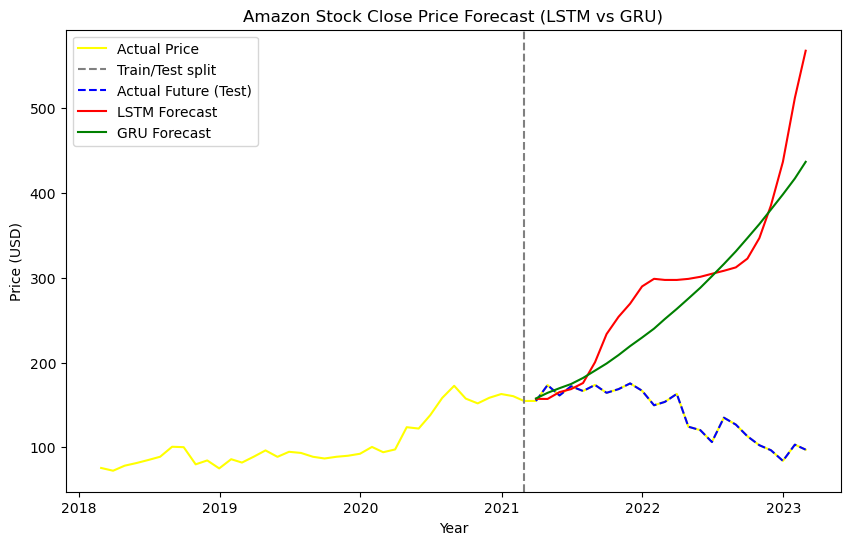

In [60]:
# Plot Amazon Stock Close Price Forecast (LSTM vs GRU)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(monthly_df.index, monthly_df.values, label='Actual Price', color='yellow')
plt.axvline(x=train_series.index[-1], color='gray', linestyle='--', label='Train/Test split')
plt.plot(test_series.index, test_series.values, label='Actual Future (Test)', color='blue', linestyle='--')
plt.plot(pred_series_lstm.index, pred_series_lstm.values, label='LSTM Forecast', color='red')
plt.plot(pred_series_gru.index, pred_series_gru.values, label='GRU Forecast', color='green')
plt.title('Amazon Stock Close Price Forecast (LSTM vs GRU)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()
